# Yield Prediction Models: XGBoost, Linear Regression, Random Forest and ANN 

#### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings

#### Loading ALS Dataset

In [3]:
warnings.filterwarnings("ignore")

data_path = "agricultural_survey_dataset.csv"
data = pd.read_csv(data_path)

### EDA

In [4]:
data.head()

,year,district,farm_id,area_under_crop,sector,crop_type,value_pesticides/herbicides,fertilizer_used_kg/hectare,average_rainfall,average_temperature,yield
0,2012,Makonde,404851,3.42,A1,Maize,67.32,161.33,77.87,15.27,3.75
1,2012,Makonde,401613,1.71,A1,Maize,13.02,176.28,77.87,15.27,1.61
2,2012,Makonde,404394,4.06,A1,Maize,75.33,285.77,77.87,15.27,6.80
3,2012,Makonde,408019,1.54,A1,Maize,44.04,60.40,77.87,15.27,1.86
4,2012,Makonde,405522,1.73,A1,Maize,95.72,139.79,77.87,15.27,1.79


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9368 entries, 0 to 9367
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         9368 non-null   int64  
 1   district                     9368 non-null   object 
 2   farm_id                      9368 non-null   int64  
 3   area_under_crop              9248 non-null   float64
 4   sector                       9368 non-null   object 
 5   crop_type                    9168 non-null   object 
 6   value_pesticides/herbicides  8905 non-null   float64
 7   fertilizer_used_kg/hectare   9318 non-null   float64
 8   average_rainfall             8914 non-null   float64
 9   average_temperature          9368 non-null   float64
 10  yield                        8922 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 805.2+ KB


In [6]:
data.isnull().sum()

year                             0
district                         0
farm_id                          0
area_under_crop                120
sector                           0
crop_type                      200
value_pesticides/herbicides    463
fertilizer_used_kg/hectare      50
average_rainfall               454
average_temperature              0
yield                          446
dtype: int64

In [7]:
selected_columns = [
    "area_under_crop",
    "value_pesticides/herbicides",
    "fertilizer_used_kg/hectare",
    "average_rainfall",
    "average_temperature"
]

data[selected_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
area_under_crop,9248.0,12.615059,21.875662,0.50,1.9900,4.225,17.4700,185.979878
value_pesticides/herbicides,8905.0,235.242758,279.902093,0.01,51.6400,94.050,368.1900,999.930000
fertilizer_used_kg/hectare,9318.0,151.268394,81.556007,0.00,80.3025,150.810,219.7575,299.950000
average_rainfall,8914.0,87.807502,23.582871,66.30,69.0300,77.870,103.0000,147.230000
average_temperature,9368.0,15.799417,0.492683,15.07,15.2700,15.870,16.0700,16.830000


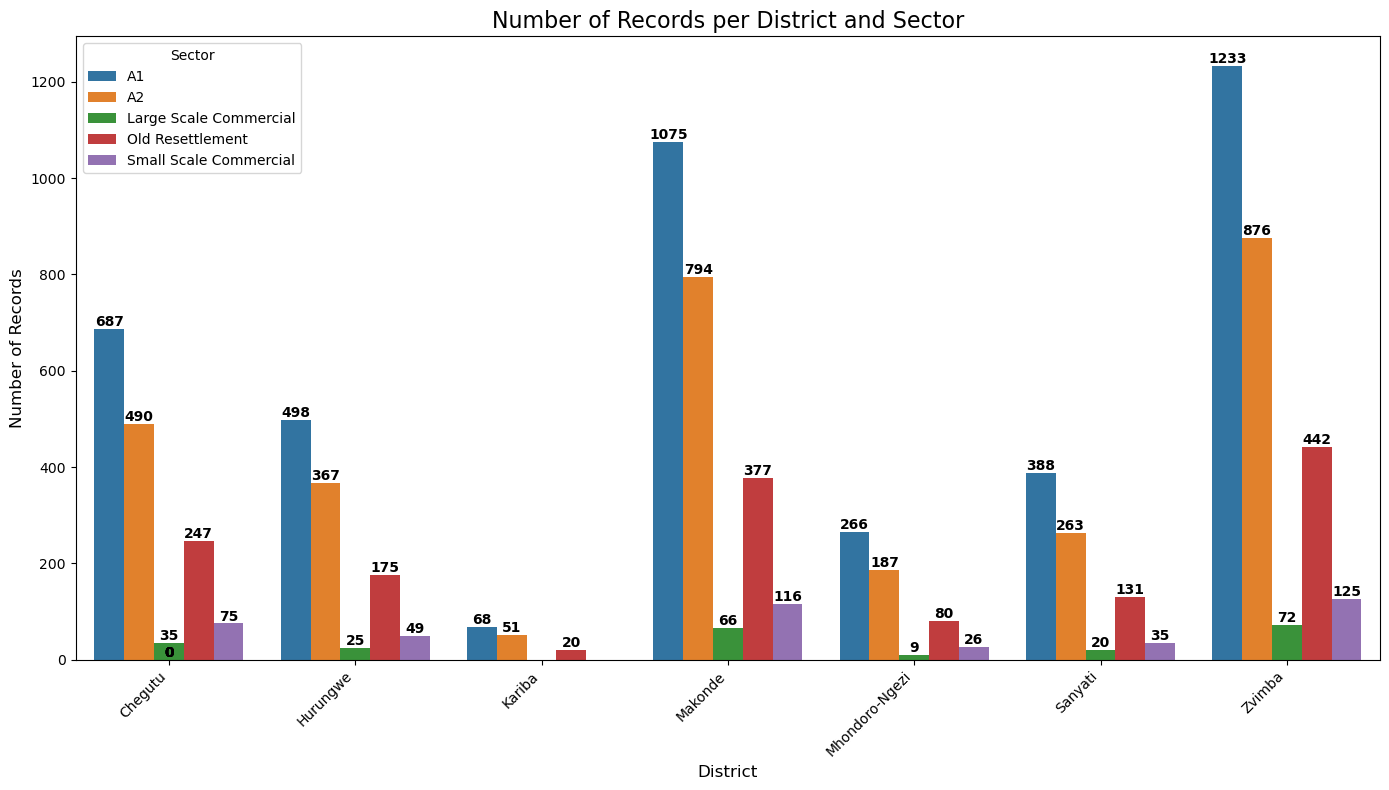

In [8]:
district_sector_counts = data.groupby(["district", "sector"]).size().reset_index(name="record_count")

# Plotting the bar plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=district_sector_counts,
    x="district",
    y="record_count",
    hue="sector",
    ci=None
)

# Adding the count on top of each bar
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',  # Display the count
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the count
        ha='center', va='center', fontsize=10, color='black', fontweight='bold', xytext=(0, 5), textcoords='offset points'
    )

plt.title("Number of Records per District and Sector", fontsize=16)
plt.xlabel("District", fontsize=12)
plt.ylabel("Number of Records", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sector", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

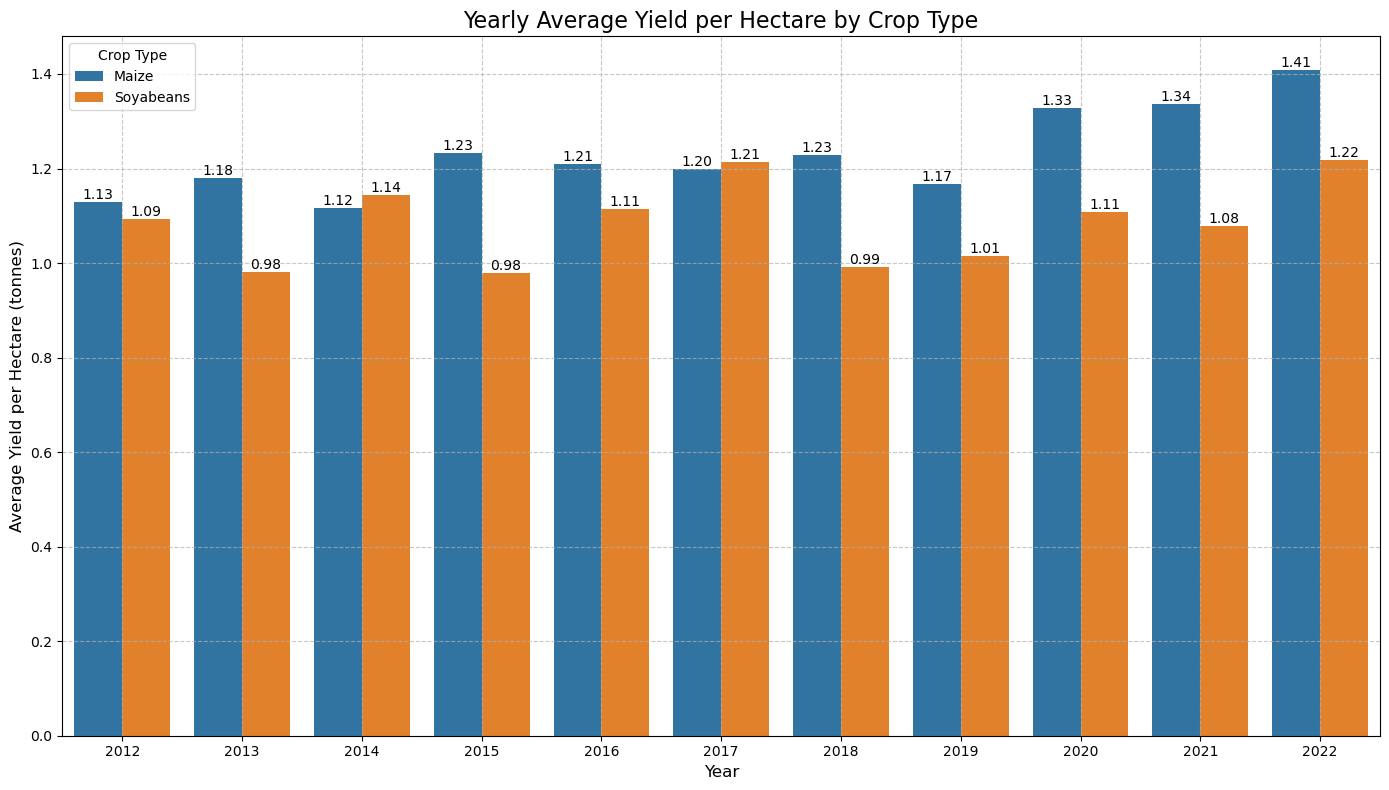

In [9]:
# Calculate average yield per hectare
average_yield = (
    data.groupby(['year', 'crop_type'])
    .apply(lambda group: group['yield'].sum() / group['area_under_crop'].sum())
    .reset_index(name='yield_per_hectare')
)

# Plotting
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=average_yield,
    x="year",
    y="yield_per_hectare",
    hue="crop_type",
    ci=None
)

# Add annotations on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10)

# Add titles and labels
plt.title("Yearly Average Yield per Hectare by Crop Type", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Yield per Hectare (tonnes)", fontsize=12)
plt.legend(title="Crop Type", fontsize=10)
plt.grid(visible=True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
data.shape

(9368, 11)

In [11]:
print("Columns in DataFrame:", data.columns)

Columns in DataFrame: Index(['year', 'district', 'farm_id', 'area_under_crop', 'sector', 'crop_type',
       'value_pesticides/herbicides', 'fertilizer_used_kg/hectare',
       'average_rainfall', 'average_temperature', 'yield'],
      dtype='object')


In [12]:
sector_counts = data['sector'].value_counts()
sector_percentage = (sector_counts / len(data)) * 100
print("Sector Contribution towards Total Records (%):")
print(sector_percentage)

# ii. Calculate the average yield per sector
average_yield_per_sector = data.groupby('sector')['yield'].mean()
print("\nAverage Yield per Sector:")
print(average_yield_per_sector)

Sector Contribution towards Total Records (%):
sector
A1                        44.993595
A2                        32.322801
Old Resettlement          15.713066
Small Scale Commercial     4.547395
Large Scale Commercial     2.423143
Name: count, dtype: float64

Average Yield per Sector:
sector
A1                          3.584062
A2                         18.167761
Large Scale Commercial    171.747032
Old Resettlement            2.669390
Small Scale Commercial     78.735865
Name: yield, dtype: float64


### Visualization

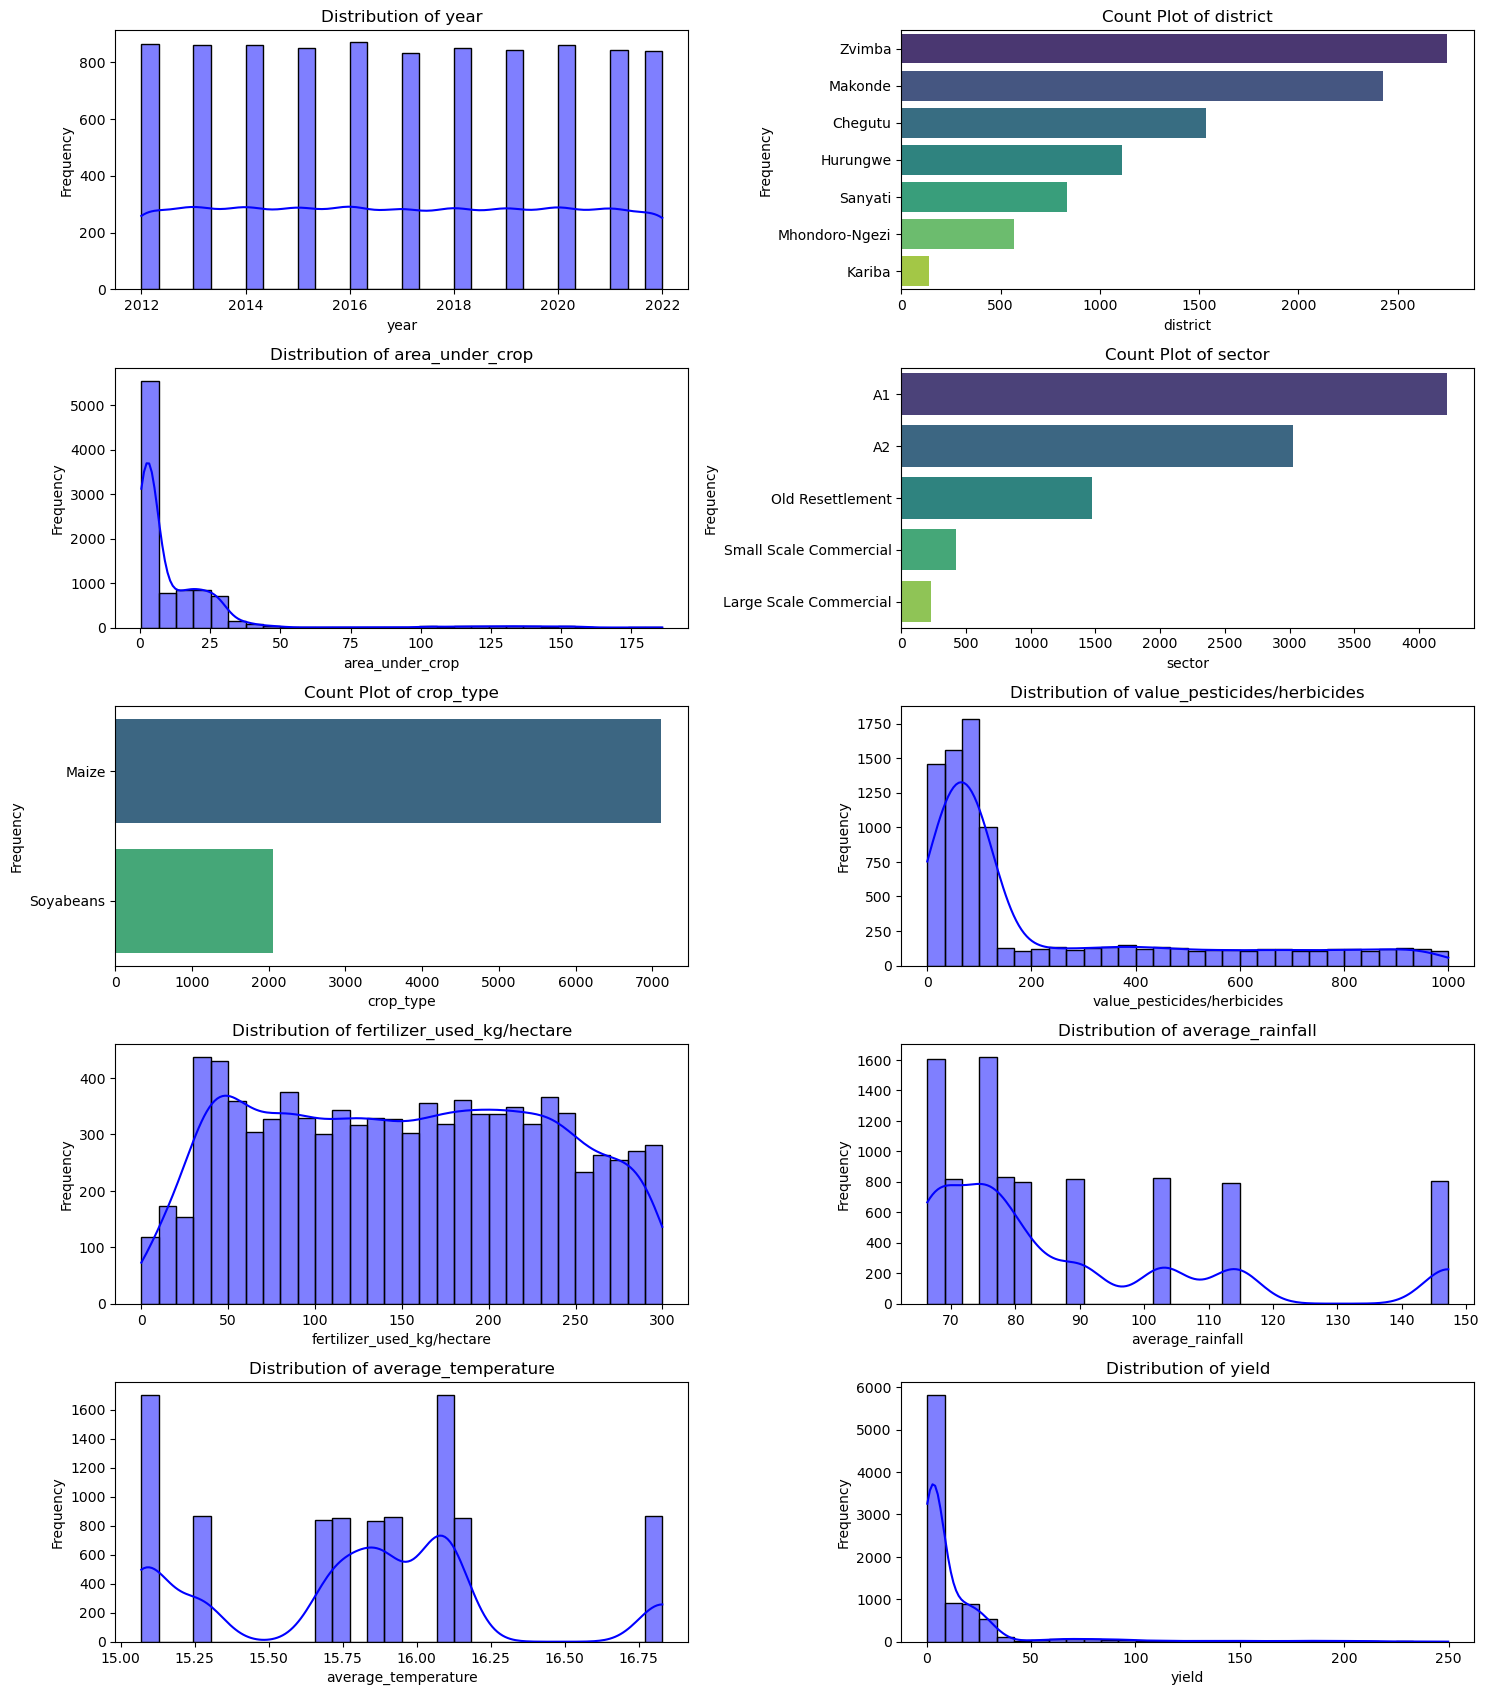

In [13]:
columns_to_plot = [
    'year', 'district', 'area_under_crop', 'sector', 'crop_type', 
    'value_pesticides/herbicides', 'fertilizer_used_kg/hectare',
    'average_rainfall', 'average_temperature', 'yield'
]

plt.figure(figsize=(15, 20))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(len(columns_to_plot) // 2 + 1, 2, i)
    if data[column].dtype in ['float64', 'int64']:
        sns.histplot(data[column], kde=True, bins=30, color='blue')
        plt.title(f'Distribution of {column}')
    else:
        sns.countplot(y=data[column], palette='viridis', order=data[column].value_counts().index)
        plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

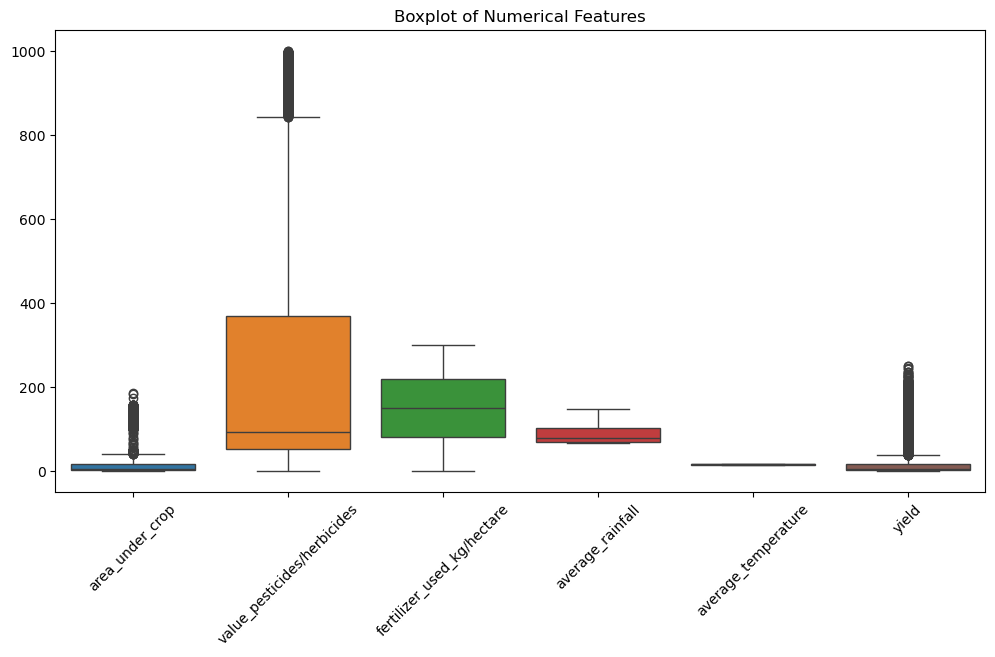

In [14]:
# Boxplot for numerical features
numerical_cols = ['area_under_crop',	'value_pesticides/herbicides',	'fertilizer_used_kg/hectare',	
                   'average_rainfall',	'average_temperature',	'yield']
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[numerical_cols])
plt.title('Boxplot of Numerical Features')
plt.xticks(rotation=45)
plt.show()

In [15]:
data['district'].value_counts()

district
Zvimba            2748
Makonde           2428
Chegutu           1534
Hurungwe          1114
Sanyati            837
Mhondoro-Ngezi     568
Kariba             139
Name: count, dtype: int64

## Preprocessing 

### Dropping farm_id column

In [16]:
data = data.drop(columns=['farm_id'])

### Missing Values

In [17]:
# Update numerical_columns after dropping farm_id
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Fill missing values (if any) only for numerical columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

### Detecting and Handling Outliers

In [18]:
def handle_outliers(data, columns, threshold=1.5):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])


In [19]:
data.shape

(9368, 10)

### Normalization

In [20]:
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
# numerical_columns = [col for col in numerical_columns if col != 'year']

handle_outliers(data, numerical_columns)

scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [21]:
categorica_data = pd.get_dummies(data, columns=['crop_type', 'sector'])

In [22]:
data

,year,district,area_under_crop,sector,crop_type,value_pesticides/herbicides,fertilizer_used_kg/hectare,average_rainfall,average_temperature,yield
0,0.0,Makonde,0.073559,A1,Maize,0.087195,0.537856,0.142963,0.113636,0.096935
1,0.0,Makonde,0.030482,A1,Maize,0.016853,0.587698,0.142963,0.113636,0.035923
2,0.0,Makonde,0.089682,A1,Maize,0.097571,0.952725,0.142963,0.113636,0.183892
3,0.0,Makonde,0.026199,A1,Maize,0.057038,0.201367,0.142963,0.113636,0.043051
4,0.0,Makonde,0.030986,A1,Maize,0.123985,0.466044,0.142963,0.113636,0.041055
...,...,...,...,...,...,...,...,...,...,...
9363,1.0,Chegutu,0.845466,Small Scale Commercial,Maize,1.000000,0.502784,0.000000,0.357955,1.000000
9364,1.0,Chegutu,0.414642,Small Scale Commercial,Maize,0.390014,0.124954,0.000000,0.357955,1.000000
9365,1.0,Chegutu,0.401549,Small Scale Commercial,Maize,0.718378,0.577296,0.000000,0.357955,1.000000
9366,1.0,Chegutu,0.566678,Small Scale Commercial,Maize,0.193044,0.604867,0.000000,0.357955,1.000000


### Defining Target Feature

In [23]:
# Encode Categorical Columns
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

X = data.drop(columns=['yield'])
y = data['yield']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model Training and Tuning

### Linear Regression

In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

### Random Forest

In [25]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

### XGBoost

In [26]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

### ANN

In [27]:
ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

ann_model.compile(optimizer='adam', loss='mean_squared_error')
ann_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
ann_preds = ann_model.predict(X_test).flatten()

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Model Evaluation

### Evaluate Each Model

               Model       MSE       MAE        R²
0  Linear Regression  0.019333  0.077020  0.801836
1      Random Forest  0.013215  0.049069  0.864543
2            XGBoost  0.014592  0.052870  0.850428
3                ANN  0.016669  0.064927  0.829143


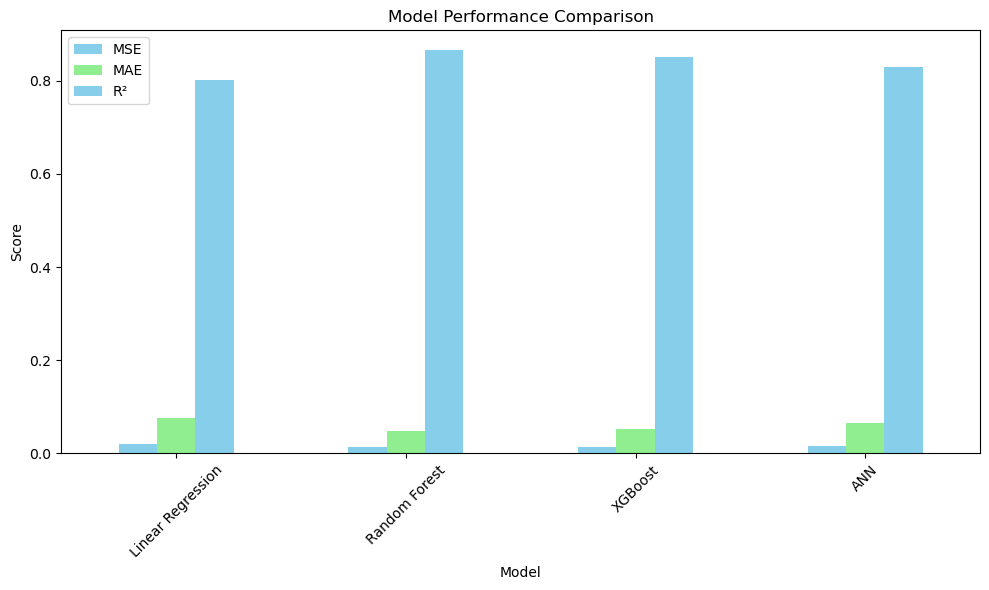

In [28]:
# Initialize an empty list to store evaluation results
evaluation_results = []

# Function to evaluate and store model performance
def evaluate_model(y_test, y_pred, model_name):
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results in the evaluation_results list
    evaluation_results.append({
        'Model': model_name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })

# Assuming y_test, lr_preds, rf_preds, xgb_preds, ann_preds are already defined
evaluate_model(y_test, lr_preds, "Linear Regression")
evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, xgb_preds, "XGBoost")
evaluate_model(y_test, ann_preds, "ANN")

# Convert the evaluation results into a DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# Display the cross-tabulation (comparison table)
print(evaluation_df)

# Plot the results for better visualization
evaluation_df.set_index('Model').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen'])
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualizing Model Evaluation

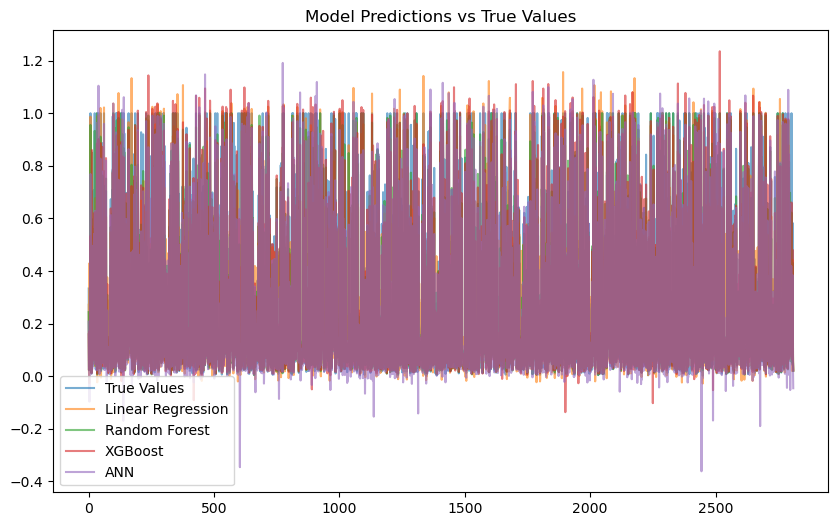

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="True Values", alpha=0.6)
plt.plot(lr_preds, label="Linear Regression", alpha=0.6)
plt.plot(rf_preds, label="Random Forest", alpha=0.6)
plt.plot(xgb_preds, label="XGBoost", alpha=0.6)
plt.plot(ann_preds, label="ANN", alpha=0.6)
plt.legend()
plt.title("Model Predictions vs True Values")
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
List of Identified Features and Their Aggregated Importance:
                          Feature  Normalized Importance
0                 area_under_crop               0.856421
14  sector_Small Scale Commercial               0.658485
12  sector_Large Scale Commercial               0.525958
11   

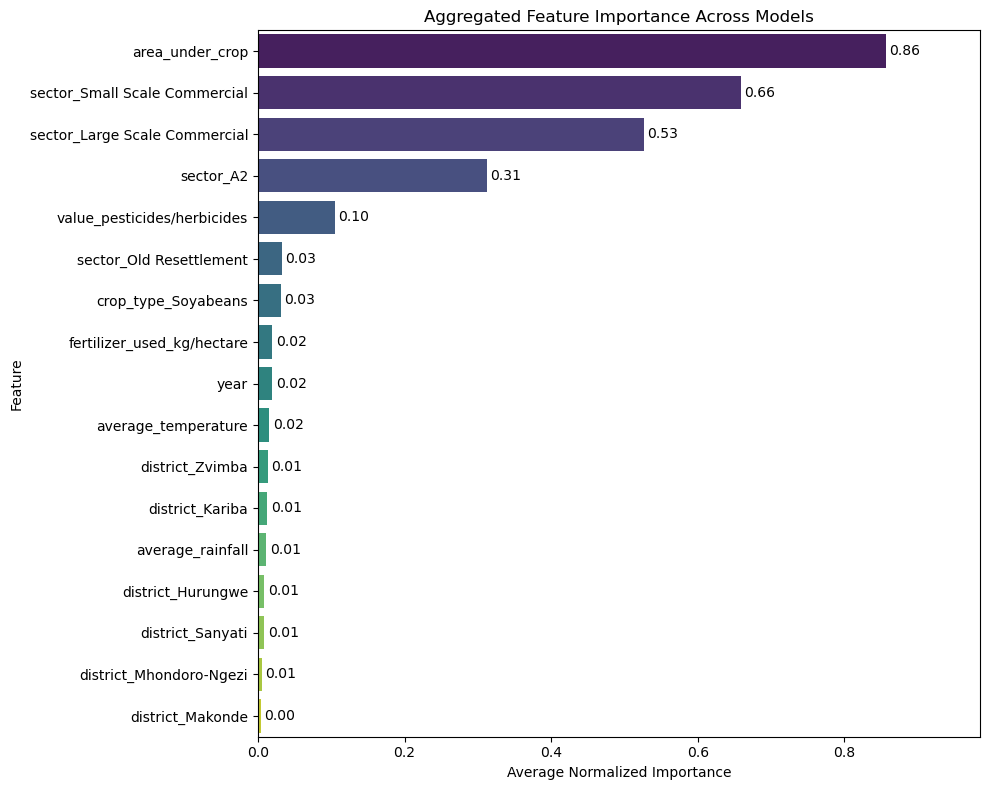

In [30]:
# Function to extract feature importances
def get_feature_importances(model, X_train, model_name):
    if model_name == 'Linear Regression':
        importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': np.abs(model.coef_)
        })
    elif model_name == 'Random Forest' or model_name == 'XGBoost':
        importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        })
    elif model_name == 'ANN':
        ann_preds = model.predict(X_test).flatten()
        baseline_mse = mean_squared_error(y_test, ann_preds)
        
        feature_importances = []
        for col in X_train.columns:
            X_test_shuffled = X_test.copy()
            X_test_shuffled[col] = np.random.permutation(X_test_shuffled[col])
            shuffled_preds = model.predict(X_test_shuffled).flatten()
            shuffled_mse = mean_squared_error(y_test, shuffled_preds)
            importance = shuffled_mse - baseline_mse
            feature_importances.append((col, importance))
        
        importance = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])
    
    return importance.sort_values(by='Importance', ascending=False)

# Aggregate feature importances across models
all_importances = []
models = [(lr_model, 'Linear Regression'), 
          (rf_model, 'Random Forest'), 
          (xgb_model, 'XGBoost'), 
          (ann_model, 'ANN')]

for model, name in models:
    importances = get_feature_importances(model, X_train, name)
    importances['Model'] = name
    all_importances.append(importances)

# Combine all importances into one DataFrame
combined_importances = pd.concat(all_importances)

# Normalize importances within each model
scaler = MinMaxScaler()
combined_importances['Normalized Importance'] = combined_importances.groupby('Model')['Importance'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Aggregate normalized importances by feature
final_importances = combined_importances.groupby('Feature')['Normalized Importance'].mean().reset_index()

# Sort by overall importance
final_importances = final_importances.sort_values(by='Normalized Importance', ascending=False)

# List all identified features with their importance
print("List of Identified Features and Their Aggregated Importance:")
print(final_importances)

# Plot aggregated feature importance with values on bars
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='Normalized Importance', y='Feature', data=final_importances, palette='viridis')

# Add text annotations for each bar
for p in ax.patches:
    value = p.get_width()
    ax.text(value + 0.005,  # X position: value + small offset
            p.get_y() + p.get_height()/2,  # Y position: centered
            f'{value:.2f}',  # Formatted value with 2 decimal places
            va='center',      # Vertical alignment
            fontsize=10)      # Adjust font size if needed

# Adjust xlim to ensure text fits
max_x = max(p.get_width() for p in ax.patches)
ax.set_xlim(0, max_x * 1.15)  # Add 15% padding on right side

plt.title('Aggregated Feature Importance Across Models')
plt.xlabel('Average Normalized Importance')
plt.ylabel('Feature')
plt.tight_layout()  # Improve spacing
plt.show()

### Hyperparameter Tunning

In [31]:
# Define the parameter grids
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the models
xgb_model = XGBRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# Perform GridSearchCV for XGBRegressor
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, 
                               cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Perform GridSearchCV for RandomForestRegressor
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, 
                              cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best parameters and scores
print("Best parameters for XGBRegressor:", xgb_grid_search.best_params_)
print("Best score for XGBRegressor:", -xgb_grid_search.best_score_)  # Convert negative MSE to positive

print("Best parameters for RandomForestRegressor:", rf_grid_search.best_params_)
print("Best score for RandomForestRegressor:", -rf_grid_search.best_score_)  # Convert negative MSE to positive

# Use the best models to make predictions
xgb_best_model = xgb_grid_search.best_estimator_
rf_best_model = rf_grid_search.best_estimator_

xgb_preds = xgb_best_model.predict(X_test)
rf_preds = rf_best_model.predict(X_test)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for XGBRegressor: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
Best score for XGBRegressor: 0.011814196059211747
Best parameters for RandomForestRegressor: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best score for RandomForestRegressor: 0.011131510190417415


In [32]:
# Best parameters for XGBRegressor
xgb_best_model = XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=50,
    subsample=1.0,
    random_state=42
)

# Best parameters for RandomForestRegressor
rf_best_model = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=200,
    random_state=42
)

# Train the models with the best parameters
xgb_best_model.fit(X_train, y_train)
rf_best_model.fit(X_train, y_train)

# Make predictions
xgb_preds = xgb_best_model.predict(X_test)
rf_preds = rf_best_model.predict(X_test)

# Calculate R² and RMSE for XGBRegressor
xgb_r2 = r2_score(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

# Calculate R² and RMSE for RandomForestRegressor
rf_r2 = r2_score(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

# Print results
print("XGBRegressor:")
print(f"R²: {xgb_r2:.4f}")
print(f"RMSE: {xgb_rmse:.4f}")

print("\nRandomForestRegressor:")
print(f"R²: {rf_r2:.4f}")
print(f"RMSE: {rf_rmse:.4f}")


XGBRegressor:
R²: 0.8709
RMSE: 0.1122

RandomForestRegressor:
R²: 0.8753
RMSE: 0.1103


In [33]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import numpy as np

# Define a function to create the model for KerasRegressor
def create_ann_model(optimizer='adam', neurons_1=64, neurons_2=32):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_1, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(neurons_2, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the model using KerasRegressor
ann_model = KerasRegressor(model=create_ann_model, verbose=0)

# Define the parameter grid
param_grid = {
    'model__optimizer': ['adam', 'sgd'],
    'model__neurons_1': [32, 64, 128],
    'model__neurons_2': [16, 32, 64],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100]
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=ann_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_result.best_params_)
print("Best Score (Negative MSE):", grid_result.best_score_)

# Test the new ANN model with optimal parameters
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE:", mse)
print("Test R2 Score:", r2)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'batch_size': 16, 'epochs': 100, 'model__neurons_1': 64, 'model__neurons_2': 32, 'model__optimizer': 'sgd'}
Best Score (Negative MSE): -0.013902892461117908
Test MSE: 0.015241623553710828
Test R2 Score: 0.8437701150353996
